# Template fitting for richness-mass binned by cosi
## Zhuowen Zhang
### Updates
* First Created April 16, 2018
* Nov. 16: Changed file reading for halo run catalog. read_shape_param is more flexible. 
* Sept. 23, 2021: The final version used in the Triaxiality paper used Model3 in the halorun catalog 


In [100]:
import numpy as np
import sys
import pickle
sys.path.append('/home/zzbenjamin94/Desktop/Astronomy/Research/DES_Galaxy_Cluster')

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt
from tools.plot_utils import plot_pretty
plot_pretty()
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
from tools.setup.setup import tools_home_dir, home_dir, bigdata_home_dir
import astropy.io.fits as fits
shapedir = home_dir()+'output/buzzard/halo_shape/'
tpltdir = home_dir() + 'output/lmda_cosi_chains/hrun/all/120121/run4_'
#tpltdir = home_dir() + 'output/lmda_cosi_chains/redM_Buzzard/v1.3/'
buzzdir = home_dir() + 'output/buzzard/'
bigdatadir = bigdata_home_dir()
toolsdir = tools_home_dir()
homedir = home_dir()

import astropy.io.fits as pyfits
import ConfigParser
import healpy as hp
import treecorr
import os

from repo.halo_shape.halo_shape_stats_backend import kmeans_stats, student_t_test
from repo.halo_shape.read_shape_param import halo_bin_stat, read_shape_param
from lmda_cosi_model import *

### Import halo files, apply cuts, and extract parameters

#### For the redM full run catalog

Cuts to the data applied:
* Mass cut M > 1e13
* $\lambda_{obs}$ > 20
* shape convergence cut

#### For the projection catalog

Jan 16, 2019. Cuts to the data applied:
* Mass cut M > 1e13
* $\lambda_{obs}$ > 10
* shape convergence cut

#### Halorun catalog

In [90]:
from repo.halo_shape.read_shape_param import read_shape_param
import numpy.lib.recfunctions as rfn

filename = 'halo_shape_hruncut_allz.npy'
halo_shape = np.load(shapedir+filename)
num_bcut = len(halo_shape)

#Apply convergence cut
conv_cut = np.where(halo_shape['converge']==True)
halo_shape = halo_shape[conv_cut]
print "After convergence cut ", len(halo_shape), " out of initial ", num_bcut, " remain." 

#Find corresponding richness and mass of halos_ID in hrun, after shape cut
filename = bigdatadir + 'Buzzard_Sims/v1.6/halo_run/'+'buzzard-0_1.6_y3_run_halos_lambda_chisq_chto_fullhalo_final_chto.fit'
hrun_list = fits.open(filename)
hrun_data = hrun_list[1].data


After convergence cut  133637  out of initial  134908  remain.


#### Do a lambda cut of 40. If converges problem may be with the mass cut off. 

#### Todo: Change back to lambda > 20. 

In [91]:
### Sparse sampling
hrun_data = hrun_data[::2]

In [92]:
#First do a lambda cut
lmda_cut = np.where((hrun_data['LAMBDA_CHISQ'] >= 20))
hrun_data = hrun_data[lmda_cut]
print "lmda for hrun completed: ", len(hrun_data), " halos remain"

#Mass cut
mcut = np.where((hrun_data['M200B'] >= 5e13))
hrun_data = hrun_data[mcut]
print "mcut hrun completed: ", len(hrun_data), " halos remain"


#Cut for hrun_data
shapecut = [ind for (ind, val) in enumerate(hrun_data['HALOID']) if val in halo_shape['halos_ID']]
hrun_data = hrun_data[shapecut]
print "shapecut for hrun completed: ", len(hrun_data), " halos remain"


ID_cut = [ind for (ind, val) in enumerate(halo_shape['halos_ID']) if val in hrun_data['HALOID']] 
halo_shape = halo_shape[ID_cut] 
print "ID_cut for halo_shape completed: ", len(halo_shape), " halos remain"

assert len(halo_shape) == len(hrun_data), 'hrun_data and halo_shape don\'t have equal number of halos'

lmda for hrun completed:  30423  halos remain
mcut hrun completed:  30423  halos remain
shapecut for hrun completed:  26620  halos remain
ID_cut for halo_shape completed:  26620  halos remain


In [94]:
##Shorthand name for relevant halo/redM parameters 
richness= hrun_data.LAMBDA_CHISQ 
halos_M = hrun_data.M200B 
halos_ID_shapecut, q, s, cos_i = read_shape_param(halo_shape, convcut=True)

### Binning Halos Files -- by cos(i) and richness, creating redshift cut

In [95]:
from repo.halo_shape.read_shape_param import halo_bin_stat

#Bin by cosine
cosi_num_bin = 5
cosi_bin_edge = np.linspace(0,1,cosi_num_bin+1)
cosi_bins = []
for i in range(cosi_num_bin):
    cosi_bins.append([cosi_bin_edge[i], cosi_bin_edge[i+1]])
    
cosi_bins_ind = halo_bin_stat(cos_i, cosi_bins)
    
#Bin by richness
lmda_max = np.max(richness)
lmda_bins = [[20,30],[30,50],[50,lmda_max]] #upper limit must match lower limit of next bin
num_lmda_bins = len(lmda_bins)
lmda_bins_ind = halo_bin_stat(richness, lmda_bins)
print 'Maximum richness after cuts is ', lmda_max

#Contains all halos. List should be of length with an array that contains all halos.
all_ind = [np.arange(len(q))]

Maximum richness after cuts is  360.17416


In [96]:
#Binning richness by cos_i
num_bins = len(cosi_bins)
lnM200b_binned = [None]*num_bins
lnl_binned = [None]*num_bins

lnl = np.log(richness)
lnM200b = np.log(halos_M)

for i, cosi_bin in enumerate(cosi_bins):
    lnM200b_binned[i] = np.log(halos_M[cosi_bins_ind[i]])
    lnl_binned[i] = np.log(richness[cosi_bins_ind[i]])

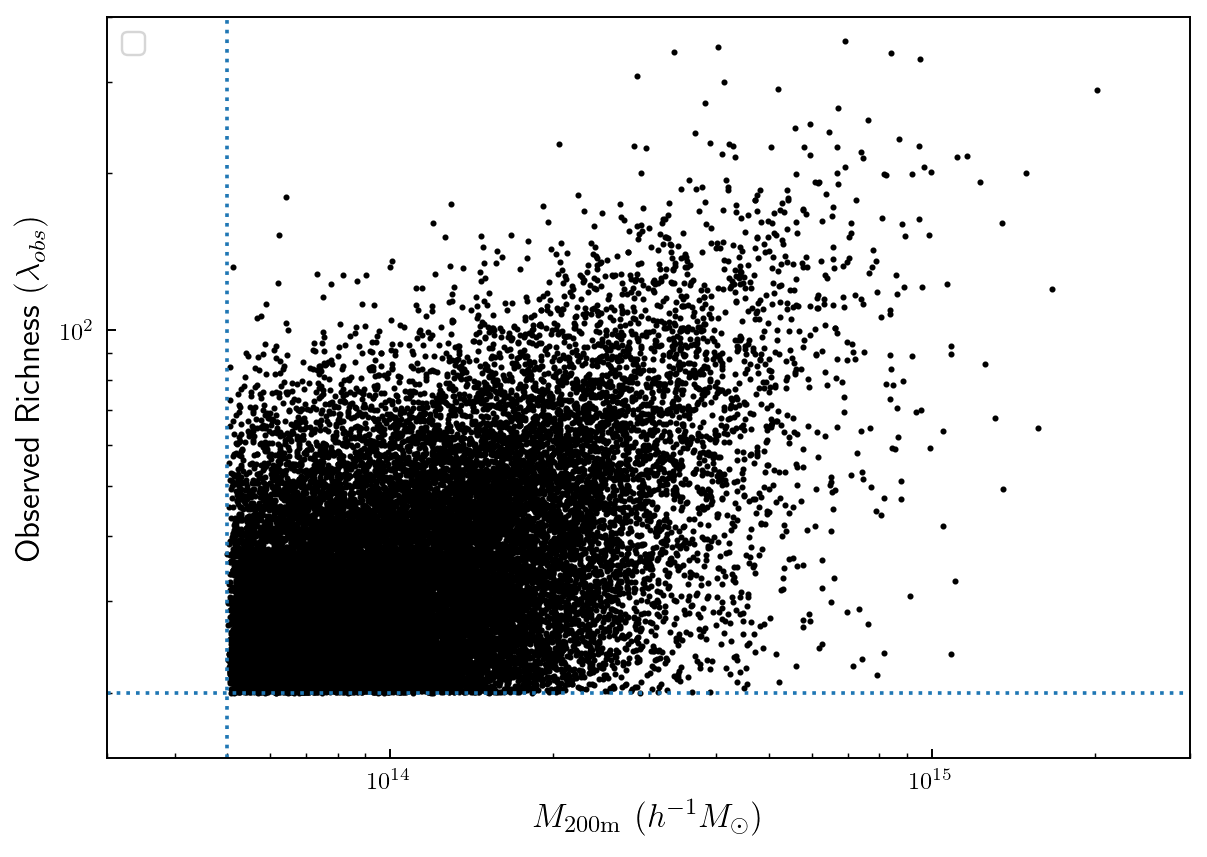

In [97]:
#### Plotting
# Todo: Add inset to show small differences in trend. 
#Plot the trendlines for different bins
fig, axs = plt.subplots(1 ,1, tight_layout=True, figsize=(7,5))
axs.plot(halos_M, richness, 'k.', markersize=3)
axs.axhline(20, linestyle='dotted')
axs.axvline(5e13, linestyle='dotted')
axs.set_yscale('log')
axs.set_xscale('log')
axs.legend(loc='upper left', fontsize=12)
axs.set_xlabel(r'$M_{\rm 200m}$ $(h^{-1}M_\odot)$',fontsize=14)
axs.set_ylabel('Observed Richness $(\lambda_{obs})$',fontsize=14)
axs.set_ylim((15,400))
axs.set_xlim((3e13,3e15))

plt.show()

## Generating fake data

### Testing with Fake Data

#### Test with Model 1

The posteriors found through sampling the fake data is in the ballpark and has good contours but is off in absolute value. 

| Parameter   |   True   | Found   |
|-------------|----------|---------|
|  As         |   20.08  |   5.74  |   
|  Bs         |   0.5    |  0.677  | 
|  sig0s      |   0.5    |  0.628  | 

This is before I matched the hmf of fake data with that used in model. Model2 results are after adjustment and they match well. 

#### Test with Model 2
The posteriors found through sampling the fake data is in the ballpark and has good contours but is off in absolute value. 

| Parameter   |   True   | Found                  |
|-------------|----------|---------               |
|  $A_0$         |   22.19  |   22.77 $\pm$ 0.39   |   
|  $A_1$         |   24.53  |   24.21 $\pm$ 0.40   |   
|  $A_2$         |   27.11  |   27.59 $\pm$ 0.42  |   
|  $A_3$         |   29.96  |   30.21 $\pm$ 0.43  |   
|  $A_4$         |   33.11  |   32.59 $\pm$ 0.44  |   
|  Bs         |   0.6    |  0.59 $\pm$ 0.01       | 
|  sig0s      |   0.3    |  0.30 $\pm$ 0.01       | 

Results agree. 

#### Test with model 3
This model varies A only, and inputs the best fit B and sig0 found from the maximum posterior from model2. 
Unlike model2, this model input does not allow input of lnl and lnM from different bins. To find posterior for different
bins need to call the model each time, creating a MCMC folder for each bin. 


| Parameter   |   True   | Found                  |
|-------------|----------|---------               |
|  $A$         |   20.09  |   20.08 $\pm$ 0.37   |   

Results agree. 

## Template for richness-mass

Assume a linear relation in richness-mass in the log-log plane, and with a log-normal scatter. Free parameters are A the intercept, B the slope, and sig0 the instrinsic scatter.

The truncated Gaussian at $\lambda = 20$ is normalized with the mass function from the random halo catalog in the Buzzard simulations. 

The linear relation between richness and mass is
$$
\mu_{\log(\lambda)} = \log{A} + B*(\log{M} - \log{10^{14}})
$$

with instrinsic scatter
$$
\sigma^2(\log{\lambda}) = \sigma_0^2 + \frac{\exp{\mu}-1}{2\exp{\mu}}.
$$

The posterior probability is 
$$
P(A,B,\sigma|\lambda, M) = \frac{1}{N(A,B,\sigma, M)}P(\lambda, M | A, B, \sigma) P (A, B, \sigma),
$$

with normalization factor
$$
N(A, B, \sigma, M) = \int dM \int_{20}^{+\infty} d \lambda P(\lambda| M, A, B, \sigma) P(M)
= \int dM(0.5 - 0.5 \mathrm{erf}\big(\frac{\mathrm{ln} 20 - \mu{(\mathrm{ln} \lambda)}}{\sqrt{2(\sigma_0^2+ \frac{\mathrm{exp} ( \mu{(\mathrm{ln} \lambda)})-1}{\mathrm{exp} ( 2\mu{(\mathrm{ln} \lambda)})})}} \big) P(M).
$$

$P(M)$ is sampled from the randomly selected halo (see code tools.halo_mass_template) and integration is done by tabulating P(M) into 100 bins. 

**See lmda_cosi_model.py for explanation of different models**



### Generating MCMC Chains with real data

In [78]:
#from repo.richness_mass.lmda_cosi_model import make_model, make_model2, make_model3 #this takes a while because of tab hmf
from pymc import *
from pymc import DiscreteUniform, Normal, uniform_like, TruncatedNormal
from pymc import Metropolis
from numpy.random import randn
import matplotlib.pyplot as plt
from scipy.special import erf
from chainconsumer import ChainConsumer

#### For model1

In [98]:
#MCMC chain setup
num=100
n_iter=num*2000
n_burn=num*100
n_thin=num    

In [53]:

#data input

mcmc_filestr = range(len(cosi_bins))
#For binned by cos_i
for i in mcmc_filestr:
    print '\n Bin number ', i
    mcmc_folder = tpltdir  + 'p_lmda_cosi_'+str(mcmc_filestr[i])+'_model1'
    cosi_bin_ind = cosi_bins_ind[i]
    M=pymc.Model(make_model(lnl_binned[i], lnM200b_binned[i]))
    mc=MCMC(M, db='txt', dbname=mcmc_folder)
    mc.sample(iter=n_iter, burn=n_burn, thin=n_thin)


 Bin number  0
 [-----------------100%-----------------] 1000000 of 1000000 complete in 505.7 sec
 Bin number  1
 [-----------------100%-----------------] 1000000 of 1000000 complete in 509.3 sec
 Bin number  2
 [-----------------100%-----------------] 1000000 of 1000000 complete in 510.2 sec
 Bin number  3
 [-----------------100%-----------------] 1000000 of 1000000 complete in 517.2 sec
 Bin number  4
 [-----------------100%-----------------] 1000000 of 1000000 complete in 553.0 sec

In [101]:
#Combined for model1
mcmc_folder = tpltdir + 'p_lmda_cosi_'+'all_'+'model1'
M=pymc.Model(make_model(lnl, lnM200b))
mc=MCMC(M, db='txt', dbname=mcmc_folder)
mc.sample(iter=n_iter, burn=n_burn, thin=n_thin)

 [-----------------100%-----------------] 200000 of 200000 complete in 835.0 sec

#### For model2

In [55]:
#This is the data input format for model2
#For different bins. Vary A but keep B and sigma fixed. 
mcmc_folder = tpltdir  + 'p_lmda_cosi_' +'all_'+'model2'
M=pymc.Model(make_model2(lnl_binned, lnM200b_binned)) #Use make_model2 for binned data. 
mc=MCMC(M, db='txt', dbname=mcmc_folder)
mc.sample(iter=n_iter, burn=n_burn, thin=n_thin)

 [-----------------100%-----------------] 1000000 of 1000000 complete in 5447.8 sec

#### For model3

In [56]:
mcmc_folder = tpltdir + 'p_lmda_cosi_'+'all'+'_model2'

#Need to input the global B, sigma0 found from model2. Model 3 only makes sense after running and inputting the posterior
#from model2
c = ChainConsumer() 
for i in range(1):
    cosi_bin_min = cosi_bins[i][0]; cosi_bin_max = cosi_bins[i][1]
    As=np.genfromtxt(mcmc_folder+'/Chain_0/A_{}.txt'.format(i))
    Bs=np.genfromtxt(mcmc_folder+'/Chain_0/B.txt')
    sig0s=np.genfromtxt(mcmc_folder+'/Chain_0/sigma0.txt')

    # plot the parameter constraints
    data=np.vstack( (As, Bs, sig0s) ).T
    c.add_chain(data, parameters=[r"$A$", r"$B$", r"$\sigma_0$"], \
                name=r'Template for $cos(i)\in[%.1f, %.1f)$'%(cosi_bin_min, cosi_bin_max))

    c.configure(statistics="max_shortest")

c_posterior = c.analysis.get_summary()    
B_post_model2 = c_posterior["$B$"][1] #Find max likelihood value
sig0_post_model2 = c_posterior["$\sigma_0$"][1] #Find max likelihood value
    
B_allfit =  B_post_model2           #hrun B_max: 0.761646
sigma0_allfit = sig0_post_model2    #hrun sigma0_max: 0.582257
print B_allfit, sigma0_allfit



0.809587565954033 0.5333648596760232


/home/zzbenjamin94/anaconda2/lib/python2.7/site-packages/chainconsumer/analysis.py:264: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist, edges = np.histogram(data, bins=bins, normed=True, weights=chain.weights)


In [57]:
#For different cosine bins
mcmc_filestr=range(cosi_num_bin)
for i in mcmc_filestr:
    print '\n Bin number ', i
    mcmc_folder = tpltdir  + 'p_lmda_cosi_'+str(mcmc_filestr[i])+'_model3'
    cosi_bin_ind = cosi_bins_ind[i]
    M=pymc.Model(make_model3(lnl_binned[i], lnM200b_binned[i], B_allfit, sigma0_allfit))
    mc=MCMC(M, db='txt', dbname=mcmc_folder)
    mc.sample(iter=n_iter, burn=n_burn, thin=n_thin)


 Bin number  0
 [-----------------100%-----------------] 1000000 of 1000000 complete in 169.4 sec
 Bin number  1
 [-----------------100%-----------------] 1000000 of 1000000 complete in 171.1 sec
 Bin number  2
 [-----------------100%-----------------] 1000000 of 1000000 complete in 172.6 sec
 Bin number  3
 [-----------------100%-----------------] 1000000 of 1000000 complete in 174.3 sec
 Bin number  4
 [-----------------100%-----------------] 1000000 of 1000000 complete in 185.6 sec

In [58]:
#Combined for model3
mcmc_folder = tpltdir + 'p_lmda_cosi_'+'all_'+'model3'
M=pymc.Model(make_model3(lnl, lnM200b, B_allfit, sigma0_allfit))
mc=MCMC(M, db='txt', dbname=mcmc_folder)
mc.sample(iter=n_iter, burn=n_burn, thin=n_thin)

 [-----------------100%-----------------] 1000000 of 1000000 complete in 359.6 sec

## Posterior distribution

In [59]:
from scipy.stats import sem

#x parameters are the mean of each cosi_bin
x_pos = np.zeros(len(cosi_bins))
for i, cosi_bin in enumerate(cosi_bins):
    cosi_bin_min = cosi_bin[0]; cosi_bin_max = cosi_bin[1]
    x_pos[i] = (cosi_bin_max+cosi_bin_min)/2.
#print x_pos

#### For model1

In [60]:
c = ChainConsumer() #contains multiple chains across different models
for i in range(len(cosi_bins)):

    cosi_bin_min = cosi_bins[i][0]; cosi_bin_max = cosi_bins[i][1]
    mcmc_folder = tpltdir + 'p_lmda_cosi_'+str(i)+'_model1'
        
    As=np.genfromtxt(mcmc_folder+'/Chain_0/A.txt')
    Bs=np.genfromtxt(mcmc_folder+'/Chain_0/B.txt')
    sig0s=np.genfromtxt(mcmc_folder+'/Chain_0/sigma0.txt')

    # plot the parameter constraints
    data=np.vstack( (As, Bs, sig0s) ).T
    c.add_chain(data, parameters=[r"$A$", r"$B$", r"$\sigma_0$"], \
                name=r'Model1 for $cos(i)\in[%.1f, %.1f)$'%(cosi_bin_min, cosi_bin_max))
    c.configure(statistics="max_shortest")
    
#Combined
mcmc_folder = tpltdir + 'p_lmda_cosi_'+'all'+'_model1'
As = np.genfromtxt(mcmc_folder+'/Chain_0/A.txt')
Bs=np.genfromtxt(mcmc_folder+'/Chain_0/B.txt')
sig0s=np.genfromtxt(mcmc_folder+'/Chain_0/sigma0.txt')

data=np.vstack( (As, Bs, sig0s) ).T
c.add_chain(data, parameters=[r"$A$" , r"$B$", r"$\sigma_0$"], name=r'Model1 for all$')
c.configure(statistics="max_shortest")
#c.plot(filename="test1.png", figsize="column", truth=[A, B, sig0])

In [61]:
c_posterior = c.analysis.get_summary()

#Posterior likelihoods
lnA_post_model1 = np.zeros((len(cosi_bins)+1,3))
B_post_model1 = np.zeros((len(cosi_bins)+1,3))
sig0_post_model1 = np.zeros((len(cosi_bins)+1,3))

#For model1
for i in range(0,6):
    lnA_post_model1[i] = np.log(c_posterior[i]["$A$"])
    B_post_model1[i] = c_posterior[i]["$B$"]
    sig0_post_model1[i] = c_posterior[i]["$\sigma_0$"]

#### For model2

In [62]:
c = ChainConsumer() #contains multiple chains across different models
mcmc_folder = tpltdir +'p_lmda_cosi_'+'all'+'_model2'

for i in range(len(cosi_bins)):
    cosi_bin_min = cosi_bins[i][0]; cosi_bin_max = cosi_bins[i][1]
    As=np.genfromtxt(mcmc_folder+'/Chain_0/A_{}.txt'.format(i))
    
    Bs=np.genfromtxt(mcmc_folder+'/Chain_0/B.txt')
    sig0s=np.genfromtxt(mcmc_folder+'/Chain_0/sigma0.txt')

    #plot the parameter constraints
    data=np.vstack( (As, Bs, sig0s) ).T
    c.add_chain(data, parameters=[r"$A$" , r"$B$", r"$\sigma_0$"], \
                    name=r'Template for $cos(i)\in[%.1f, %.1f)$'%(cosi_bin_min, cosi_bin_max))
    c.configure(statistics="max_shortest")

In [63]:
c_posterior = c.analysis.get_summary()

B_post_model2 = np.zeros((1,3)) #Universal fit
sig0_post_model2 = np.zeros((1,3)) #Univesal fit across cosine bins

#B, sigma0 for model2
for i in range(0,1):
    B_post_model2[i] = c_posterior[i]["$B$"]
    sig0_post_model2[i] = c_posterior[i]["$\sigma_0$"]

#### For model3

In [64]:
c = ChainConsumer() #contains multiple chains across different models
for i in range(len(cosi_bins)):
    cosi_bin_min = cosi_bins[i][0]; cosi_bin_max = cosi_bins[i][1]
    mcmc_folder = tpltdir +'p_lmda_cosi_'+str(i)+'_model3'
    As = np.genfromtxt(mcmc_folder+'/Chain_0/A.txt')
    data = As
    c.add_chain(data, parameters=[r"$A$"], name=r'Template for $cos(i)\in[%.1f, %.1f)$'%(cosi_bin_min, cosi_bin_max))
    c.configure(statistics="max_shortest")
    
#Combined
mcmc_folder = tpltdir + 'p_lmda_cosi_'+'all'+'_model3'
As = np.genfromtxt(mcmc_folder+'/Chain_0/A.txt')
data = As
c.add_chain(data, parameters=[r"$A$"], name=r'Model3 for $cos(i)\in[%.1f, %.1f)$'%(cosi_bin_min, cosi_bin_max))
c.configure(statistics="max_shortest")
#c.plot(filename="test1.png", figsize="column", truth=[A, B, sig0])

In [65]:
c_posterior = c.analysis.get_summary()

lnA_post_model3 = np.zeros((len(cosi_bins)+1,3)) #A plus the combined fit
    
#A for model3
for i in range(0,6):
    lnA_post_model3[i] = np.log(c_posterior[i]["$A$"])

### Table of Best FIt Parameters

In [66]:
print "{:20s} {:20s} {:20s}".format("low", "max", "high")

print "lnA for model1"
for i in range(0,6):
    print lnA_post_model1[i]
    print "Upper error:", lnA_post_model1[i][2] - lnA_post_model1[i][1] 
    print "Lower error:", lnA_post_model1[i][1] - lnA_post_model1[i][0] 
    
print "\n B for model1"
for i in range(0,6):
    print B_post_model1[i]
    print "Upper error:", B_post_model1[i][2] - B_post_model1[i][1] 
    print "Lower error:", B_post_model1[i][1] - B_post_model1[i][0] 


print "\n sig0 for model1"
for i in range(0,6):
    print sig0_post_model1[i]
    print "Upper error:", sig0_post_model1[i][2] - sig0_post_model1[i][1] 
    print "Lower error:", sig0_post_model1[i][1] - sig0_post_model1[i][0] 
    
print "\n B for model2"
print B_post_model2
print "Upper error:", B_post_model2[0][2] - B_post_model2[0][1] 
print "Lower error:", B_post_model2[0][1] - B_post_model2[0][0] 

print "\n sigma_0 for model2"
print sig0_post_model2
print "Upper error:", sig0_post_model2[0][2] - sig0_post_model2[0][1] 
print "Lower error:", sig0_post_model2[0][1] - sig0_post_model2[0][0] 

print "\n lnA for model3"
for i in range(0,6):
    print lnA_post_model3[i]
    print "Upper error:", lnA_post_model3[i][2] - lnA_post_model3[i][1] 
    print "Lower error:", lnA_post_model3[i][1] - lnA_post_model3[i][0] 


low                  max                  high                
lnA for model1
[2.79699442 2.87153363 2.91158356]
Upper error: 0.040049929992405975
Lower error: 0.07453921679517173
[2.79662237 2.8490379  2.9071028 ]
Upper error: 0.05806489396427361
Lower error: 0.052415530847826464
[2.97250872 3.01553903 3.06266981]
Upper error: 0.047130773498590184
Lower error: 0.04303030844754607
[2.911972   2.96934509 3.01252766]
Upper error: 0.04318257608398479
Lower error: 0.05737308279038489
[3.20533398 3.25034373 3.27074143]
Upper error: 0.020397706200941723
Lower error: 0.045009740553465516
[2.96996054 2.99140242 3.01238906]
Upper error: 0.020986640179277316
Lower error: 0.021441875703989144

 B for model1
[0.80147588 0.83396961 0.87559483]
Upper error: 0.04162521831558397
Lower error: 0.03249372519409155
[0.79967617 0.83160265 0.87001072]
Upper error: 0.03840806771622696
Lower error: 0.03192648244226959
[0.71143205 0.75635344 0.78204559]
Upper error: 0.02569215562633087
Lower error: 0.044921388

## Processing the posterior likelihood statistics

#### For testing an individual model. Make markdown if not necessary

## Plotting results from all models

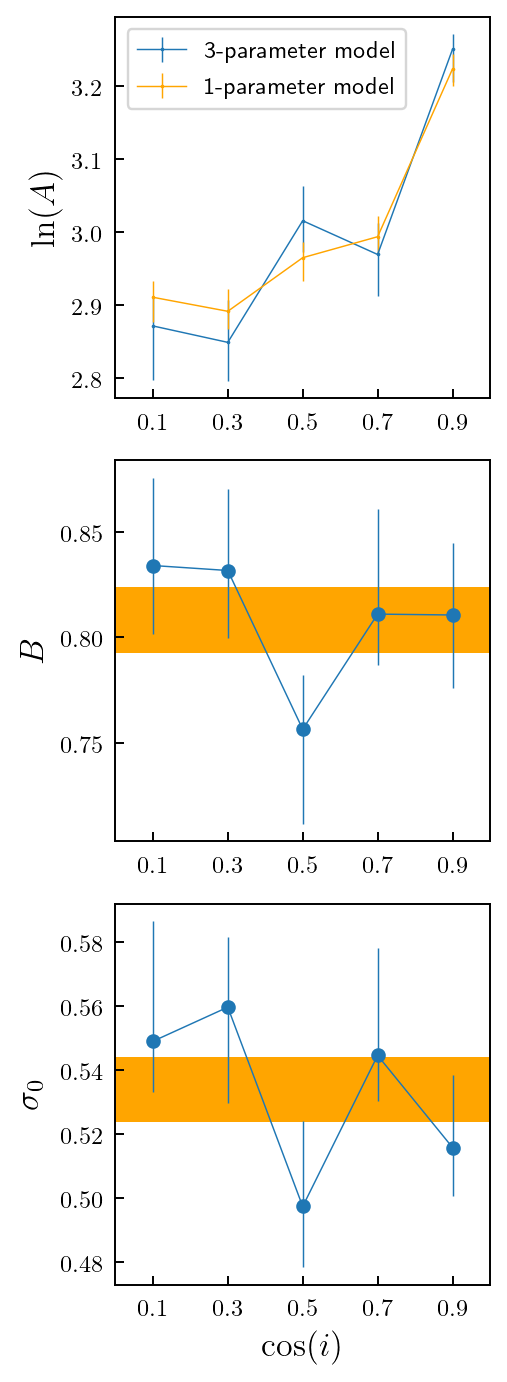

In [67]:
    #Posterior. For each paramater array contains 3 indexes -- low, max posterior, and high range. 
    '''
    funk = c_posterior[i]["$A$"] reads the A parameter statistic of the i-th chain. 
    The statistic is read as array of min, mean, max values of statistic (e.g. max_shhortest),
    so that funk[1], for instance,  is the mean value of A in the ith chain. 
    '''

    #Plotting the posteriors #########################################################
    #Plotting posterior for lnA
    fig, axs = plt.subplots(3,1, tight_layout=True, figsize=(3,8))
    subtitles = [r'$\ln(A)$', r'$B$', r'$\sigma_0$']
    stat_name = ["$A$", "$B$", "$\sigma_0$"]

    axs[0].errorbar(x_pos, lnA_post_model1[:-1,1], \
                    yerr=[lnA_post_model1[:-1,1]-lnA_post_model1[:-1,0], lnA_post_model1[:-1,2]-lnA_post_model1[:-1,1]], \
                    linewidth=0.6, marker='o',markersize=0.5, label='3-parameter model')

    axs[0].errorbar(x_pos, lnA_post_model3[:-1,1], \
                    yerr=[lnA_post_model3[:-1,1]-lnA_post_model3[:-1,0], lnA_post_model3[:-1,2]-lnA_post_model3[:-1,1]], \
                    linewidth=0.6, marker='o', color='orange', markersize=0.5, label='1-parameter model')    

    #Plotting posterior for B

    axs[1].errorbar(x_pos, B_post_model1[:-1,1], \
                    yerr=[B_post_model1[:-1,1]-B_post_model1[:-1,0], B_post_model1[:-1,2]-B_post_model1[:-1,1]], \
                    linewidth=0.6, marker='o',markersize=5, label='3-param model')

    xband = np.linspace(0,1,5)
    axs[1].fill_between(xband, B_post_model2[:,0], B_post_model2[:,2], \
                    facecolor='orange', interpolate=False, label='1-param model')  

    #Plotting posterior for sigma0
    axs[2].errorbar(x_pos, sig0_post_model1[:-1,1], \
                    yerr=[sig0_post_model1[:-1,1]-sig0_post_model1[:-1,0], sig0_post_model1[:-1,2]-sig0_post_model1[:-1,1]], \
                    linewidth=0.6, marker='o',markersize=5, label='3-param model')

    axs[2].fill_between(xband, sig0_post_model2[:,0], sig0_post_model2[:,2], \
                    facecolor='orange', interpolate=False, label='1-param model')  

    for i in range(3):
        axs[i].set_xlim((0,1))
        axs[i].set_xticks(x_pos)
        axs[i].set_ylabel(subtitles[i], size=14)
        #axs[i].set_xlabel(r'$\cos(i)$', size=14) 

    axs[2].set_xlabel(r'$\cos(i)$', size=14) 
    axs[0].legend(fontsize=10)
    #plt.savefig('richness_mass_modelparams_cosibinned_v1.3.png')
    plt.show()

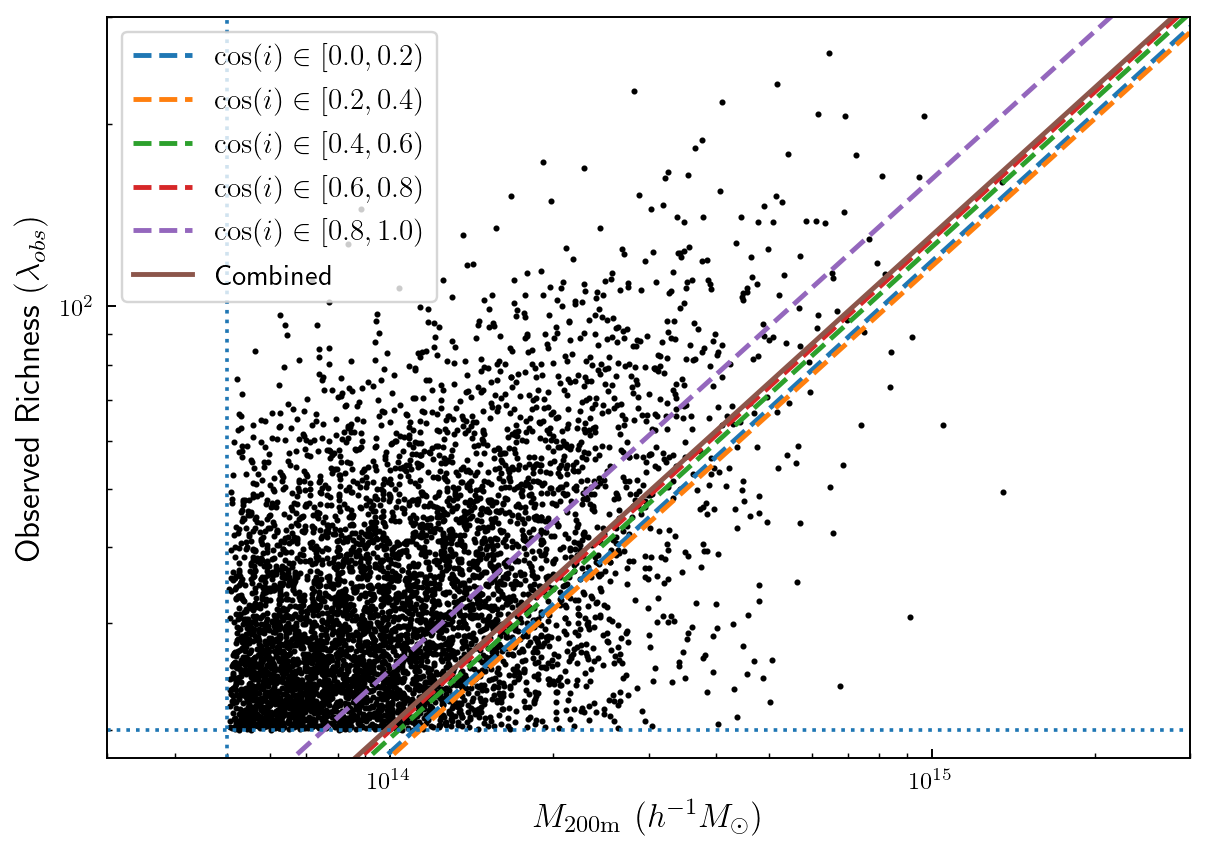

In [68]:
# Todo: Add inset to show small differences in trend. 
#Plot the trendlines for different bins
fig, axs = plt.subplots(1 ,1, tight_layout=True, figsize=(7,5))
axs.plot(halos_M, richness, 'k.', markersize=3)

lnM_range = np.arange(25,38,0.1)
B_cosi_maxL = B_post_model2[0,1]; sig0_cosi_maxL = sig0_post_model2[0,1]
for i, cosi_bin in enumerate(cosi_bins):
    cosi_bin_min = cosi_bin[0]; cosi_bin_max = cosi_bin[1]
    lnA_cosi_maxL = lnA_post_model3[i,1]; 
    mu_lnl_model = lnA_cosi_maxL + (B_cosi_maxL)*(lnM_range-np.log(10)*14)
    sig_lnl_model=np.sqrt(sig0_cosi_maxL**2+(np.exp(mu_lnl_model)-1)/(np.exp(2*mu_lnl_model)))
    axs.plot(10**(lnM_range/np.log(10)), np.exp(mu_lnl_model), linewidth=2, linestyle='dashed', \
        label='$\cos(i) \in [{:.1f}, {:.1f})$'.format(cosi_bin_min,cosi_bin_max))
             
#for all data points    
lnA_cosi_maxL = lnA_post_model3[-1,1]; B_cosi_maxL = B_post_model2[0,1]; sig0_cosi_maxL = sig0_post_model2[0,1]
mu_lnl_model = lnA_cosi_maxL + (B_cosi_maxL)*(lnM_range-np.log(10)*14)
sig_lnl_model=np.sqrt(sig0_cosi_maxL**2+(np.exp(mu_lnl_model)-1)/(np.exp(2*mu_lnl_model)))
axs.plot(10**(lnM_range/np.log(10)), np.exp(mu_lnl_model), \
            label='Combined', linewidth=2)
axs.axhline(20, linestyle='dotted')
axs.axvline(5e13, linestyle='dotted')
axs.set_yscale('log')
axs.set_xscale('log')
axs.legend(loc='upper left', fontsize=12)
axs.set_xlabel(r'$M_{\rm 200m}$ $(h^{-1}M_\odot)$',fontsize=14)
axs.set_ylabel('Observed Richness $(\lambda_{obs})$',fontsize=14)
axs.set_ylim((18,300))
axs.set_xlim((3e13,3e15))

#Add an inset to show difference between lines

'''
a = plt.axes([0.68, 0.22, .25, .25])
for i, cosi_bin in enumerate(cosi_bins):
    cosi_bin_min = cosi_bin[0]; cosi_bin_max = cosi_bin[1]
    lnA_cosi_maxL = lnA_post_model3[i,1]; 
    mu_lnl_model = lnA_cosi_maxL + B_cosi_maxL*(lnM_range-np.log(10)*14)
    sig_lnl_model=np.sqrt(sig0_cosi_maxL**2+(np.exp(mu_lnl_model)-1)/(np.exp(2*mu_lnl_model)))
    plt.plot(10**(lnM_range/np.log(10)), np.exp(mu_lnl_model), linewidth=2, linestyle='dashed', alpha=1)
plt.plot(10**(lnM_range/np.log(10)), np.exp(mu_lnl_model), label='Combined', linewidth=2)
#plt.plot(halos_M, richness, 'k.', markersize=2)
plt.yscale('log'); plt.xscale('log')
plt.xlim((2.2e14, 3e14)); plt.ylim((47,60))   
plt.xticks((2.2e14, 3e14), (r'$2.2 \times 10^{14}$', r'$3 \times 10^{14}$'))
#plt.yticks([])
'''


#axs.axvspan(2.05e14, 2.13e14, alpha=0.5)
#axs.axhline(40)
#plt.savefig('mass_richness_cosibinned_projection.png')

plt.show()

## Comparing trends between simulations

Testing whether deviation for miscentering run and Buzzard run holds.

#### Chains for Buzzard 1 parameter model

Chains 0-4 are the cos(i) bins
Chain 5 is the combined. 

In [48]:
buzz_tplt_dir = home_dir() + 'output/lmda_cosi_chains/redM_Buzzard/v1.3/'

c_buzzard = ChainConsumer() #contains multiple chains across different models
for i in range(len(cosi_bins)):
    cosi_bin_min = cosi_bins[i][0]; cosi_bin_max = cosi_bins[i][1]
    mcmc_folder = buzz_tplt_dir + 'p_lmda_cosi_'+str(i)+'_model3'
    As = np.genfromtxt(mcmc_folder+'/Chain_0/A.txt')
    data = As
    c_buzzard.add_chain(data, parameters=[r"$A$"], name=r'Template for $cos(i)\in[%.1f, %.1f)$'%(cosi_bin_min, cosi_bin_max))
    c_buzzard.configure(statistics="max_shortest")
    
#Combined
mcmc_folder = buzz_tplt_dir + 'p_lmda_cosi_'+'all'+'_model3'
As = np.genfromtxt(mcmc_folder+'/Chain_0/A.txt')
data = As
c_buzzard.add_chain(data, parameters=[r"$A$"], name=r'Model3 for all' )
c_buzzard.configure(statistics="max_shortest")
#c.plot(filename="test1.png", figsize="column", truth=[A, B, sig0])

#### Chains for halorun 1 parameter model

In [51]:
hrun_tplt_dir = home_dir() + 'output/lmda_cosi_chains/hrun/all/092521/'

c_hrun = ChainConsumer() #contains multiple chains across different models
for i in range(len(cosi_bins)):
    cosi_bin_min = cosi_bins[i][0]; cosi_bin_max = cosi_bins[i][1]
    mcmc_folder = hrun_tplt_dir + 'p_lmda_cosi_'+str(i)+'_model3'
    As = np.genfromtxt(mcmc_folder+'/Chain_0/A.txt')
    data = As
    c_hrun.add_chain(data, parameters=[r"$A$"], name=r'Template for $cos(i)\in[%.1f, %.1f)$'%(cosi_bin_min, cosi_bin_max))
    c_hrun.configure(statistics="max_shortest")
    
#Combined
mcmc_folder = hrun_tplt_dir + 'p_lmda_cosi_'+'all'+'_model3'
As = np.genfromtxt(mcmc_folder+'/Chain_0/A.txt')
data = As
c_hrun.add_chain(data, parameters=[r"$A$"], name=r'Model3 for all') 
c_hrun.configure(statistics="max_shortest")
#c.plot(filename="test1.png", figsize="column", truth=[A, B, sig0])

#### Computing deviation from combined A in respective catalogs

The lnA_post_model3 are arrays with indices 0-2 representing low, max, and high range. 

In [53]:
c_buzz_posterior = c_buzzard.analysis.get_summary()
c_hrun_posterior = c_hrun.analysis.get_summary()

#Only consider lnA in model3
lnA_buzz_model3 = np.zeros((len(cosi_bins)+1,3)) #A plus the combined fit
delta_lnA_buzz = np.zeros((len(cosi_bins), 3)) #The deviation from the combined fit.

#For hrun
lnA_hrun_model3 = np.zeros((len(cosi_bins)+1,3)) #A plus the combined fit
delta_lnA_hrun = np.zeros((len(cosi_bins), 3)) #The deviation from the combined fit.

#A for model3 for Buzzard
print "{:20s} {:20s} {:20s}".format("low", "max", "high")
print "Buzzard"
for i in range(0,6):
    lnA_buzz_model3[i] = np.log(c_buzz_posterior[i]["$A$"])
    print lnA_buzz_model3[i]
    
#A for model3 for hrun
print "Halorun"
for i in range(0,6):
    lnA_hrun_model3[i] = np.log(c_hrun_posterior[i]["$A$"])
    print lnA_hrun_model3[i]
    #print c_hrun_posterior[i]["$A$"]

delta_lnA_buzz = lnA_buzz_model3[0:5] - lnA_buzz_model3[5] 
delta_lnA_hrun = lnA_hrun_model3[0:5] - lnA_hrun_model3[5] 

yerr_buzz = [lnA_buzz_model3[:-1,1]-lnA_buzz_model3[:-1,0] + lnA_buzz_model3[5,1] - lnA_buzz_model3[5,0], \
                 lnA_buzz_model3[:-1,1]-lnA_buzz_model3[:-1,0] + lnA_buzz_model3[5,2] - lnA_buzz_model3[5,1]]

yerr_hrun = [lnA_hrun_model3[:-1,1]-lnA_hrun_model3[:-1,0] + lnA_hrun_model3[5,1] - lnA_hrun_model3[5,0], \
                 lnA_hrun_model3[:-1,1]-lnA_hrun_model3[:-1,0] + lnA_hrun_model3[5,2] - lnA_hrun_model3[5,1]]

print delta_lnA_buzz
print delta_lnA_hrun

low                  max                  high                
Buzzard
[3.21430332 3.22522295 3.23775103]
[3.20223763 3.21433445 3.2251942 ]
[3.22977042 3.23961223 3.25098399]
[3.23152597 3.24232414 3.25093529]
[3.23665592 3.24528844 3.25385136]
[3.23009673 3.23580398 3.23937578]
Halorun
[3.22196293 3.2271173  3.23485238]
[3.2384219  3.24481063 3.25053869]
[3.25384041 3.2602024  3.26594576]
[3.30886814 3.31482471 3.32036949]
[3.42491763 3.42937042 3.43502408]
[3.30204448 3.30498405 3.30727415]
[[-0.01579341 -0.01058102 -0.00162474]
 [-0.0278591  -0.02146953 -0.01418157]
 [-0.00032631  0.00380825  0.01160821]
 [ 0.00142924  0.00652017  0.01155952]
 [ 0.00655919  0.00948446  0.01447558]]
[[-0.08008155 -0.07786675 -0.07242177]
 [-0.06362257 -0.06017342 -0.05673546]
 [-0.04820406 -0.04478166 -0.0413284 ]
 [ 0.00682366  0.00984066  0.01309533]
 [ 0.12287315  0.12438637  0.12774993]]


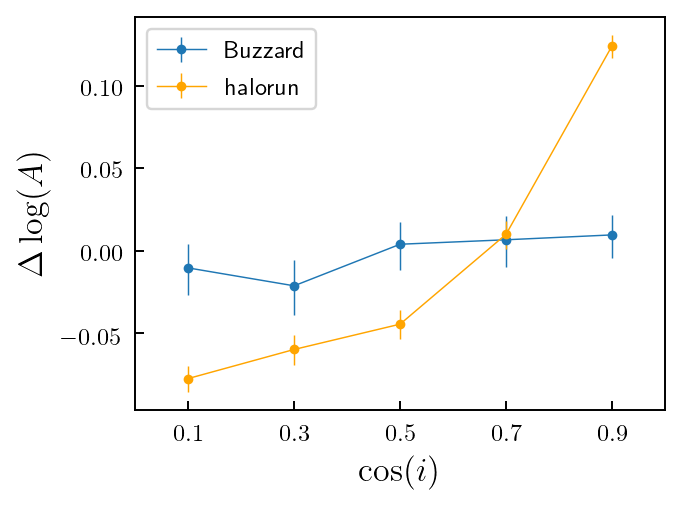

In [54]:
#Plotting the posteriors #########################################################
#x parameters are the mean of each cosi_bin
x_pos = np.zeros(len(cosi_bins))
for i, cosi_bin in enumerate(cosi_bins):
    cosi_bin_min = cosi_bin[0]; cosi_bin_max = cosi_bin[1]
    x_pos[i] = (cosi_bin_max+cosi_bin_min)/2.

#Plotting posterior for lnA
fig, axs = plt.subplots(1, tight_layout=True, figsize=(4,3))
subtitles = r'$\Delta\log(A)$'
#stat_name = ["$A$", "$B$", "$\sigma_0$"]

axs.errorbar(x_pos, delta_lnA_buzz[:,1], \
                yerr=yerr_buzz, \
                linewidth=0.6, marker='o',markersize=3, label='Buzzard')

axs.errorbar(x_pos, delta_lnA_hrun[:,1], \
                yerr=yerr_hrun, \
                linewidth=0.6, marker='o', color='orange', markersize=3, label='halorun')    


axs.set_xlim((0,1))
axs.set_xticks(x_pos)
axs.set_ylabel(subtitles, size=14)
axs.set_xlabel(r'$\cos(i)$', size=14) 

axs.set_xlabel(r'$\cos(i)$', size=14) 
axs.legend(fontsize=10)
#plt.savefig('richness_mass_modelparams_cosibinned_060718.png')
plt.show()

### Generating BIC for different models

In [ ]:
'''
Calculates the BIC for a given model.
D: mean log(x|theta) across posterior distribution theta.
k: number of free parameters
N: number of data points
'''

def calc_bic(D,k,N):
    return -2*D + k*np.log(N)

In [ ]:
for i in range(len(cosi_bins)):
    #For model 3
    mcmc_folder = tpltdir + 'p_lmda_cosi_'+str(i)+'_model3'       
    deviance = np.genfromtxt(mcmc_folder+'/Chain_0/deviance.txt')
    bic_model3 = calc_bic(np.mean(deviance), 1, len(richness[cosi_bins_ind[i]]))
    print "BIC in cosi bin ", i, "for model 3 is ", bic_model3
    
    #For model 1
    mcmc_folder = tpltdir + 'p_lmda_cosi_'+str(i)+'_model1'       
    As=np.genfromtxt(mcmc_folder+'/Chain_0/A.txt')
    deviance = np.genfromtxt(mcmc_folder+'/Chain_0/deviance.txt')
    bic_model3 = calc_bic(np.mean(deviance), 3, len(richness[cosi_bins_ind[i]]))
    print "BIC in cosi bin ", i, "for model 1 is ", bic_model3
    
#For model3 all
mcmc_folder = tpltdir + 'p_lmda_cosi_all'+'_model3'       
deviance = np.genfromtxt(mcmc_folder+'/Chain_0/deviance.txt')
bic_model3 = calc_bic(np.mean(deviance), 1, len(richness[cosi_bins_ind[i]]))
print "BIC in for all bins for model 3 is ", bic_model3

In [ ]:
std_sum =np.sqrt(0.008**2 + 0.005**2)
print np.exp(2.760) - np.exp(2.625)